# Метод прогонки и LU разложение.

Попробуем численно решить уравнение Пуассона 
$$\Delta u(x,y)=f(x,y),\quad \Delta=\partial_x^2+\partial_y^2,$$
на квадрате $(x,y)\in[-1,1]^{\times 2}$ с периодическими граничными условиями 
$$\begin{cases}
u(-1,y)=u(1,y),\;\partial_x u(-1,y)=\partial_x u(1,y),\\
u(x,-1)=u(x,1),\;\partial_y u(x,-1)=\partial_y u(x,1).
\end{cases}
$$
Для тестирования удобно использовать явнорешаемую задачу,
для примера рассмотрим правую часть специального вида 
$$f(x,y)=\cos \pi x\cos \pi y,$$
для которой аналитическое решение легко выписывается:
$$u(x,y)=-\pi^{-2}\cos\pi x\cos \pi y.$$

Выполним дискретизацию на сетке:
$$x_k=\frac{k-N}{N},\quad y_n=\frac{n-N}{N},\quad u_{kn}=u(x_k,y_n),\quad f_{kn}=f(x_k,y_n),\quad k,n=0\ldots 2N-1.$$
Произоводные заменим на центральные конечные отношения:
$$\Delta u_{kn}=\frac{u_{k+1,n}+u_{k-1,n}+u_{k,n+1}+u_{k,n-1}-4u_{kn}}{\delta^2},$$
где шаг решетки обозначен $\delta=1/N$.
В сеточной дискретизации систему можно записать в матричном виде:
$$Au=f,\quad \sum_{k',n'} A_{k,n;k',n'}u_{k',n'}=f_{k',n'}.$$
Здесь пара чисел $(k,n)$ отвечает одной координате вектора.
Элементы матрицы $A$ легко выписываются:
$$A_{k,n;k',n'}=\begin{cases}
N^2,& |n-n'|+|k-k'|=1,\\
-4N^2, & n=n', k=k',\\
0,& \text{в остальных случаях}.
\end{cases}.$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

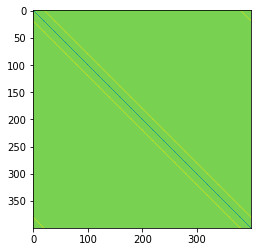

Число обусловленности 798.9999999999976


In [2]:
def matrix_A(N):
    A = np.zeros( (2*N,)*4 ) # Матрица разрежена, значит начинаем с нулевой матрицы.
    k = np.arange(2*N)[:,None] # Все возможные значения индекса для x координаты.
    kplus = ((k+1)%(2*N)) # Ячейка правее, чем указанная в массиве k.
    n = np.arange(2*N)[None,:] # Все возможные значения индекса для y координаты.
    nplus = ((n+1)%(2*N)) # Ячейка выше, чем указанная в массиве n.
    A[k,n,k,n] = -4*N**2 # Устанавливаем все диагональные элементы.
    A[k,nplus,k,n] = N**2 # Устанавливаем значения для соседей по вертикали.
    A[k,n,k,nplus] = N**2 
    A[kplus,n,k,n] = N**2 # и по горизонтали.
    A[k,n,kplus,n] = N**2 
    A[k,n,k,n] += 1 # Избегаем вырождения. СМ. ЗАДАЧУ НИЖЕ.    
    return A

def flatten_matrix(A):
    """Преобразует матрицу со сложными индексами в обучную матрицу в числовыми индексами."""
    N, M, N1, M1 = A.shape
    return A.reshape((N*M, N1*M1))

# Посмотрим на структуру матрицы.
A=matrix_A(10)
plt.imshow(flatten_matrix(A)) # Для отрисовки приведем ее к обычному виду - квадратному массиву.
plt.show()
# Матрица разреженная, причем ее можно представить трехдиагональном виде, однако на диагонали стоят блоки.

print("Число обусловленности", np.linalg.cond(flatten_matrix(A)))

Ошибка решения: 0.04784140140961821


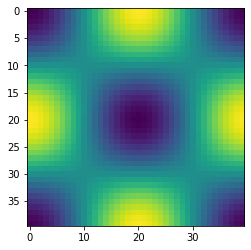

In [3]:
def grid_x(N): 
    """Считает сетку для координаты x."""
    return np.arange(2*N)/N-1

def grid_y(N): 
    """Считает сетку для координаты y."""
    return np.arange(2*N)/N-1
    
def vector_f(N):
    """Тестовая правая часть."""
    x, y = grid_x(N)[:,None], grid_y(N)[None,:]
    f = np.cos(np.pi*x)*np.cos(np.pi*y)
    f -= np.mean(f) # Поправляем вектор, так чтобы сумма элементов равнялсь нулю. СМ. ЗАДАЧУ НИЖЕ. 
    return f
    
def solve_poisson(f):
    """Решает уравнение Пуассона с заданной правой частью."""
    N = f.shape[0]//2
    A = matrix_A(N)
    u = np.linalg.solve( flatten_matrix(A), f.flatten() )
    return u.reshape(f.shape)

def explicit_u(N):
    return (-1/np.pi**2)*vector_f(N)

u = solve_poisson(vector_f(20))
# print("Приближенное решение:", u[:5,:5] )
# print("Точное решение:", explicit_u(u.shape[0]//2)[:5,:5] )
print("Ошибка решения:", np.linalg.norm( (u-explicit_u(u.shape[0]//2)).flatten(), ord=np.inf ))
plt.imshow(u.T)
plt.show()

В данном случае решать систему с помощью функции `numpy.linalg.solve` очень расточительно, так как мы не использовали информацию о структуре матрицы.
Большая часть операций при решении системы заключалась в умножении на ноль. Вашим заданием будет реализовать максимально эффективных решатель системы с фиксированной матрицей $A$ для произвольной правой части $f$. 

# Задания.

1. Зачем в функции matrix_A мы добавили константу к диагонали, а в методе vector_f мы нормировали правую часть так, чтобы ее среднее значение равнялось нулю? Можно ли было не делать эти исправления?

2. Реализуйте [метод прогонки](https://ru.wikipedia.org/wiki/Метод_прогонки) для рассмотренной системы. Матрица $A$ в нашем примере блочно-трехдиагональная матрица, каждый блок которой также трехдиагональная матрица, используйте это в вашей реализации.

3. Чем метод прогонки отличается от [LU разложения](https://ru.wikipedia.org/wiki/LU-разложение)? Как будут выглядеть матрицы $L$ и $U$ для алгоритма прогонки?

4. Вычислите определитель оператора $A$, пользуясь блочным LU разложением. 

5. (Для расширения кругозора.) Как определитель матрицы $A$ связан с [определителем оператора $\Delta$](https://en.wikipedia.org/wiki/Functional_determinant)?